# Working with location data for the NYC taxi tips challenge

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import geopandas

from geodatasets import get_path
from shapely.geometry import Point

from utils import get_trip_duration, get_rush_hours

In [2]:
taxi_train = pd.read_parquet("data/nyc-taxis-tips/train.parquet")

Retrieving the geometry (shapes, dimensions, positions etc...) of the zones where the taxis operate.

The following code cell add 4 columns to the dataframe:
- `PU_borough` = the pick-up borough name (7 values)
- `DO_borough` = the drop-off borough name (7 values)
- `PU_loc` = the coded pick up location (from 1 to 263, this is a more detail location naming than the borough)
- `DO_loc` = drop-off location

In [3]:
## TODO: optimize the following code (currently takes up to 3 minutes)
taxi_zones = geopandas.read_file("data/nyc-taxis-tips/taxi_zones/taxi_zones.shp")
display(taxi_zones)

taxi_train["PU_borough"] = ""
taxi_train["DO_borough"] = ""
taxi_train["PU_loc"] = -1
taxi_train["DO_loc"] = -1
for trip_idx, trip_row in taxi_train.iterrows():
    pu_pt = Point(trip_row["PU_location_lon"], trip_row["PU_location_lat"])
    do_pt = Point(trip_row["DO_location_lon"], trip_row["DO_location_lat"])
    pts = geopandas.GeoDataFrame(geometry=[pu_pt, do_pt], crs="EPSG:4326").to_crs(taxi_zones.crs)
    mask_pu = taxi_zones.geometry.contains(pts.iloc[0, 0])
    mask_do = taxi_zones.geometry.contains(pts.iloc[1, 0])
    if mask_pu.any():
        taxi_train.loc[trip_idx, "PU_loc"] = taxi_zones.loc[mask_pu, "LocationID"].values[0]
        taxi_train.loc[trip_idx, "PU_borough"] = taxi_zones.loc[mask_pu, "borough"].values[0]
    if mask_do.any():
        taxi_train.loc[trip_idx, "DO_loc"] = taxi_zones.loc[mask_do, "LocationID"].values[0]
        taxi_train.loc[trip_idx, "DO_borough"] = taxi_zones.loc[mask_do, "borough"].values[0]

taxi_train = taxi_train.astype({"PU_borough": "category", "DO_borough": "category"})
taxi_train["PU_borough"] = taxi_train.PU_borough.cat.rename_categories({"Bronx": 1, "Manhattan": 2, "Brooklyn": 3, "EWR": 4, "Staten Island": 5, "Queens": 6, "": 7})
taxi_train["DO_borough"] = taxi_train.DO_borough.cat.rename_categories({"Bronx": 1, "Manhattan": 2, "Brooklyn": 3, "EWR": 4, "Staten Island": 5, "Queens": 6, "": 7})

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((933100.918 192536.086, 933091.011 19..."
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,"MULTIPOLYGON (((1033269.244 172126.008, 103343..."
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((1026308.770 256767.698, 1026495.593 ..."
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.467 203714.076, 992068.667 20..."
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,"POLYGON ((935843.310 144283.336, 936046.565 14..."
...,...,...,...,...,...,...,...
258,259,0.126750,0.000395,Woodlawn/Wakefield,259,Bronx,"POLYGON ((1025414.782 270986.139, 1025138.624 ..."
259,260,0.133514,0.000422,Woodside,260,Queens,"POLYGON ((1011466.966 216463.005, 1011545.889 ..."
260,261,0.027120,0.000034,World Trade Center,261,Manhattan,"POLYGON ((980555.204 196138.486, 980570.792 19..."
261,262,0.049064,0.000122,Yorkville East,262,Manhattan,"MULTIPOLYGON (((999804.795 224498.527, 999824...."


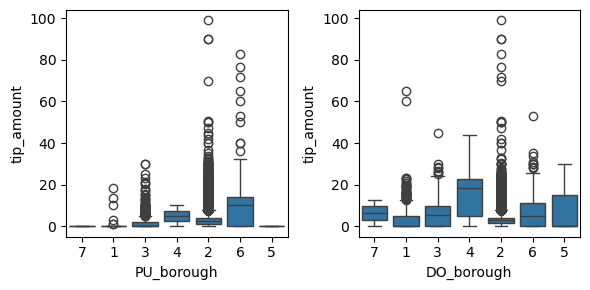

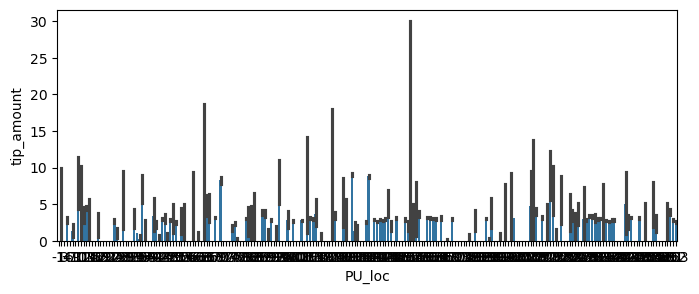

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(6, 3))
sns.boxplot(x="PU_borough", y="tip_amount", data=taxi_train, ax=axes[0])
sns.boxplot(x="DO_borough", y="tip_amount", data=taxi_train, ax=axes[1])
fig.tight_layout()
plt.show()

plt.figure(figsize=(8, 3))
sns.barplot(x="PU_loc", y="tip_amount", data=taxi_train)
plt.show()

<Axes: >

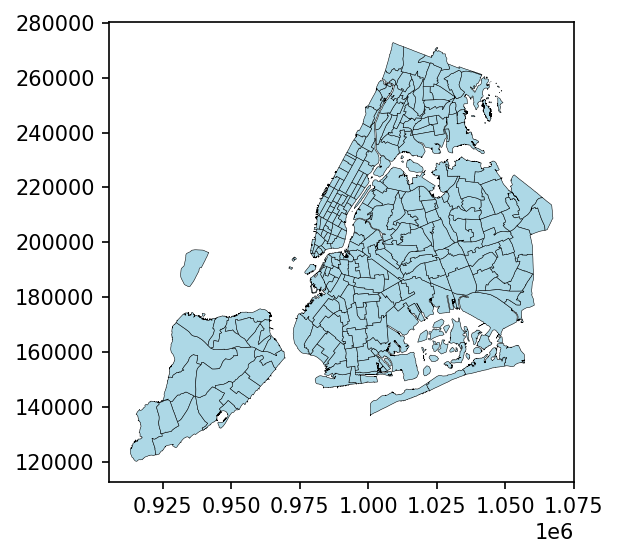

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=150)
taxi_zones.plot(ax=ax, color="lightblue", edgecolor="black", lw=0.25)

Plotting the pick-up and drop off locations on the map

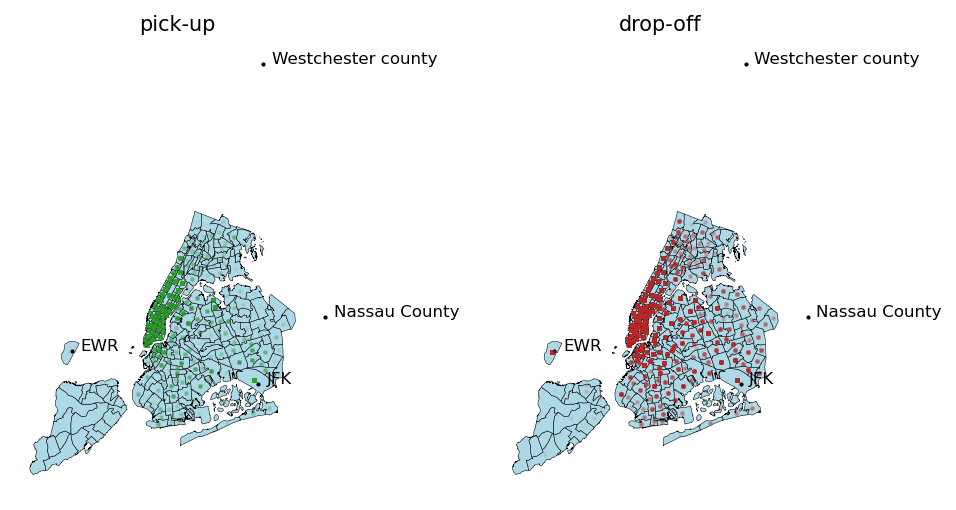

In [15]:
landmarks = [
    Point(-73.778889, 40.639722),  # JFK airport
    Point(-74.168611, 40.6925),  # Newark airport
    Point(-73.766667, 41.15),  # Westchester county
    Point(-73.6381, 40.7472),  # Nassau County
]
pts_landmarks = geopandas.GeoDataFrame(geometry=landmarks, crs="EPSG:4326")
pts_landmarks = pts_landmarks.to_crs(taxi_zones.crs) # converting to the target coordinates system
pts_landmarks["labels"] = [
    "JFK",
    "EWR",
    "Westchester county",
    "Nassau County"
]
pts_landmarks.set_index(keys="labels", drop=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3.5), dpi=150)

# departures density
lats = taxi_train["PU_location_lon"].values
longs = taxi_train["PU_location_lat"].values
points = [Point(lats[i], longs[i]) for i in range(taxi_train.shape[0])]
point_gdf = geopandas.GeoDataFrame(geometry=points, crs="EPSG:4326")
point_gdf = point_gdf.to_crs(taxi_zones.crs)
ax1 = taxi_zones.plot(ax=ax1, color="lightblue", edgecolor="black", lw=0.25)
pts_landmarks.plot(ax=ax1, color='k', marker='o', markersize=1, alpha=1, label='landmarks')
point_gdf.plot(ax=ax1, color='C2', marker='o', markersize=2, alpha=.03, label='departures')

for idx, landmark in pts_landmarks.iterrows():
    lx, ly = landmark["geometry"].bounds[:2]
    ax1.annotate(landmark["labels"], (lx, ly), (lx + 5e3, ly), fontsize=8)

# arrivals density
lats = taxi_train["DO_location_lon"].values
longs = taxi_train["DO_location_lat"].values
points = [Point(lats[i], longs[i]) for i in range(taxi_train.shape[0])]
point_gdf = geopandas.GeoDataFrame(geometry=points, crs="EPSG:4326")
point_gdf = point_gdf.to_crs(taxi_zones.crs)

ax2 = taxi_zones.plot(ax=ax2, color="lightblue", edgecolor="black", lw=0.25)
pts_landmarks.plot(ax=ax2, color='k', marker='o', markersize=1, alpha=1, label='landmarks')
point_gdf.plot(ax=ax2, color='C3', marker='o', markersize=2, alpha=.03, label='arrivals')
for idx, landmark in pts_landmarks.iterrows():
    lx, ly = landmark["geometry"].bounds[:2]
    ax2.annotate(landmark["labels"], (lx, ly), (lx + 5e3, ly), fontsize=8)

ax1.axis("off")
ax2.axis("off")
ax1.set_title("pick-up", fontsize=10)
ax2.set_title("drop-off", fontdict=dict(fontsize=10), loc="center")
fig.tight_layout(w_pad=0)
plt.show()